In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
# 安裝套件

!pip install seaborn==0.9
!pip install facets-overview
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 KB 14.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 26.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.0 which is incompatible.
tensorflow-metadata 1.12.0 requires proto

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from google.colab import widgets
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

### Step1. 讀入資料
把 adult.data 和 adult.test 上傳，並且讀入他們，方法如下。

```python
train_df = pd.read_csv("{你的 adult.data 路徑}", names=COLUMNS, sep=r'\s*,\s*', engine='python', na_values="?")
test_df = pd.read_csv("{你的 adult.test 路徑}", names=COLUMNS, sep=r'\s*,\s*', skiprows=[0], engine='python', na_values="?")
```
之後，我們合併兩個資料一起進行前處理。

In [4]:
COLUMNS = ["age 年齡",
           "workclass 工作類別",
           "fnlwgt 序號",
           "education 教育程度",
           "education_num 教育時間",
           "marital_status 婚姻",
           "occupation 職業",
           "relationship 社會角色",
           "race 種族",
           "gender 性別",
           "capital_gain 資本收益",
           "capital_loss 資本損失",
           "hours_per_week 每週工作時間",
           "native_country 國籍",
           "income_bracket 收入"]

train_df = pd.read_csv(
    "/content/drive/MyDrive/GDSC-AI/adult.data",
    names=COLUMNS,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")
test_df = pd.read_csv(
    "/content/drive/MyDrive/GDSC-AI/adult.test",
    names=COLUMNS,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?")

alldata_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print(len(train_df))
print(len(test_df))
print(len(alldata_df))
alldata_df

# Keep the original dataset
alldata_df_original = alldata_df.copy()

32561
16281
48842


In [5]:
#@title 資料視覺化

def data_visualize(df):
  fsg = FeatureStatisticsGenerator()
  dataframes = [
      {'table': df, 'name': 'Data'}]
  censusProto = fsg.ProtoFromDataFrames(dataframes)
  protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

  HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
          <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
          <facets-overview id="elem"></facets-overview>
          <script>
            document.querySelector("#elem").protoInput = "{protostr}";
          </script>"""

  html = HTML_TEMPLATE.format(protostr=protostr)
  display(HTML(html))

data_visualize(alldata_df)

### Step2. 資料前處理 Data Pre-processing
進行重要的資料前處理。

資料前處理有很多方法，以下主要示範以下三種：
- 空缺值補齊
- 區間分群
- One-hot encoding

---
**1. 空缺值補齊**

經過剛剛的資料視覺化，我們發現有缺值的變數 (Variables) 有：
- workclass
- occupation
- native_country

填值時並非隨意填補，我們必須有邏輯的思考如何補齊空值。

**2. 區間分群**

有時候數值資料 (Numerical data) 可以透過一個區間一個區間的分群，減少雜訊的量，有時也能降低模型負擔。

我們會針對 age 類別進行分群(如：青年一群、壯年一群、老年一群等)

```python
alldata_df["age_group"]=alldata_df["age 年齡"]
alldata_df["age_group"] = pd.cut(alldata_df["age_group"],bins=[16,27,37,47,57,67,77,90],labels=[0,1,2,3,4,5,6])
```

**3. One-hot encoding**
類別型資料 (Categorical data) 對於 NN 來說相對較難直接處理，我們透過編碼讓他轉換成容易處理的格式， One-hot 編碼的原理如下：

```python
假設今天有一個類別 "fruit" ，裏面有三種值 ['apple', 'banana', 'cherry']
One-hot 的原理就是：當機器看到 'apple' 時就把他看成 '第1個' ，依此類推。

所以，如果是 '第1個(apple)' 的話，我們就編碼成 [1, 0, 0]
如果是 '第2個(banana)' 的話，我們就編碼成 [0, 1, 0]
如果是 '第3個(cherry)' 的話，我們就編碼成 [0, 0, 1]

```

```python
# One-hot encoding
useddata_df_onehot = pd.get_dummies(useddata_df)
cols = useddata_df_onehot.columns

```


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'Federal-gov'),
  Text(1.5, 0, 'Local-gov'),
  Text(2.5, 0, 'Private'),
  Text(3.5, 0, 'Self-emp-inc'),
  Text(4.5, 0, 'Self-emp-not-inc'),
  Text(5.5, 0, 'State-gov'),
  Text(6.5, 0, 'Without-pay')])

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 32887 (\N{CJK UNIFIED IDEOGRAPH-8077}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 26989 (\N{CJK UNIFIED IDEOGRAPH-696D}) m

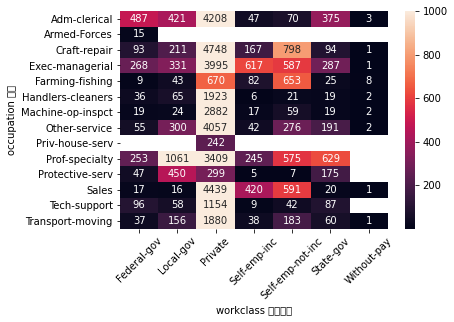

In [6]:
# 將 workclass 和 occupation 的資料視覺化，觀察兩者關係

sns.heatmap(alldata_df.groupby(['workclass 工作類別', 'occupation 職業']).size().unstack(level=0),
            vmax=1000,
            annot=True,
            fmt="g"
            )
plt.xticks(rotation=45)

In [7]:
#@title 補齊 workclass

alldata_df['workclass 工作類別'].fillna(value='Private', inplace=True)
alldata_df.info()

alldata_df.loc[alldata_df['occupation 職業'].isnull(), 'workclass 工作類別'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age 年齡                 48842 non-null  int64 
 1   workclass 工作類別         48842 non-null  object
 2   fnlwgt 序號              48842 non-null  int64 
 3   education 教育程度         48842 non-null  object
 4   education_num 教育時間     48842 non-null  int64 
 5   marital_status 婚姻      48842 non-null  object
 6   occupation 職業          46033 non-null  object
 7   relationship 社會角色      48842 non-null  object
 8   race 種族                48842 non-null  object
 9   gender 性別              48842 non-null  object
 10  capital_gain 資本收益      48842 non-null  int64 
 11  capital_loss 資本損失      48842 non-null  int64 
 12  hours_per_week 每週工作時間  48842 non-null  int64 
 13  native_country 國籍      47985 non-null  object
 14  income_bracket 收入      48842 non-null  object
dtypes: int64(6), object

array(['Private', 'Never-worked'], dtype=object)

In [8]:
#@title 補齊 occupation

workclasses = alldata_df['workclass 工作類別'].unique()

# 用相同工作類別中職業的眾數(mode)填值
occupation_mode = alldata_df.groupby('workclass 工作類別')['occupation 職業'].apply(pd.Series.mode)

for workclass in workclasses:
  if (workclass != "Never-worked"): # 記得區分出無工作者
    alldata_df.loc[(alldata_df['occupation 職業'].isnull()) & (alldata_df['workclass 工作類別'] == workclass), 'occupation 職業'] = occupation_mode[workclass][0]
  else:
    alldata_df.loc[(alldata_df['occupation 職業'].isnull()) & (alldata_df['workclass 工作類別'] == workclass), 'occupation 職業'] = "Never-worked"

alldata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age 年齡                 48842 non-null  int64 
 1   workclass 工作類別         48842 non-null  object
 2   fnlwgt 序號              48842 non-null  int64 
 3   education 教育程度         48842 non-null  object
 4   education_num 教育時間     48842 non-null  int64 
 5   marital_status 婚姻      48842 non-null  object
 6   occupation 職業          48842 non-null  object
 7   relationship 社會角色      48842 non-null  object
 8   race 種族                48842 non-null  object
 9   gender 性別              48842 non-null  object
 10  capital_gain 資本收益      48842 non-null  int64 
 11  capital_loss 資本損失      48842 non-null  int64 
 12  hours_per_week 每週工作時間  48842 non-null  int64 
 13  native_country 國籍      47985 non-null  object
 14  income_bracket 收入      48842 non-null  object
dtypes: int64(6), object

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Amer-Indian-Eskimo'),
  Text(1.5, 0, 'Asian-Pac-Islander'),
  Text(2.5, 0, 'Black'),
  Text(3.5, 0, 'Other'),
  Text(4.5, 0, 'White')])

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 26063 (\N{CJK UNIFIED IDEOGRAPH-65CF}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 31821 (\N{CJK UNIFIED IDEOGRAPH-7C4D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 26063 (\N{CJ

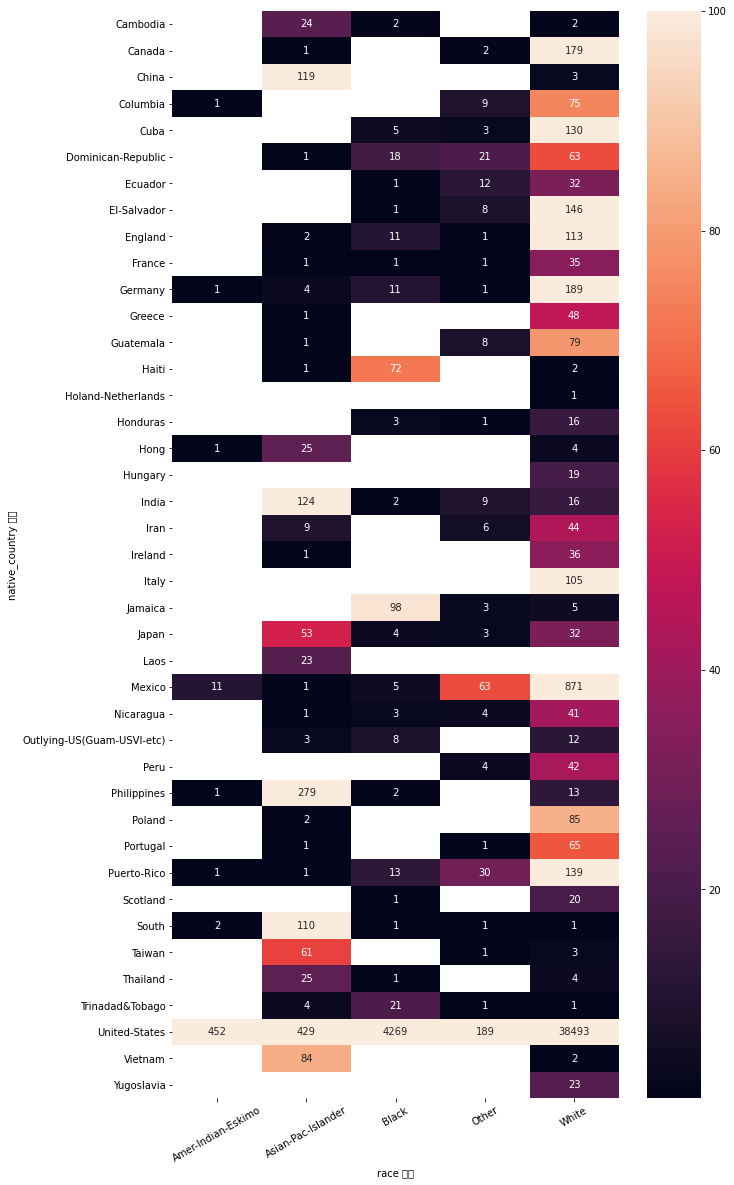

In [9]:
fig, ax = plt.subplots(figsize=(10,20))   # 調整大小
sns.heatmap(alldata_df.groupby(['race 種族', 'native_country 國籍']).size().unstack(level=0),
            vmax=100,
            annot=True,
            fmt=".0f"
            )
plt.xticks(rotation=30)

In [10]:
#@title 補齊 native_country

alldata_df['native_country 國籍'].fillna(value='United-States', inplace=True)
alldata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age 年齡                 48842 non-null  int64 
 1   workclass 工作類別         48842 non-null  object
 2   fnlwgt 序號              48842 non-null  int64 
 3   education 教育程度         48842 non-null  object
 4   education_num 教育時間     48842 non-null  int64 
 5   marital_status 婚姻      48842 non-null  object
 6   occupation 職業          48842 non-null  object
 7   relationship 社會角色      48842 non-null  object
 8   race 種族                48842 non-null  object
 9   gender 性別              48842 non-null  object
 10  capital_gain 資本收益      48842 non-null  int64 
 11  capital_loss 資本損失      48842 non-null  int64 
 12  hours_per_week 每週工作時間  48842 non-null  int64 
 13  native_country 國籍      48842 non-null  object
 14  income_bracket 收入      48842 non-null  object
dtypes: int64(6), object

In [11]:
#@title 年齡分群

alldata_df["age_group"]=alldata_df["age 年齡"] #先複製一欄出來，不要改動到原始資料
alldata_df["age_group"] = pd.cut(alldata_df["age_group"],bins=[16,27,37,47,57,67,77,90],labels=[0,1,2,3,4,5,6])

alldata_df["age_group"]

0        2
1        3
2        2
3        3
4        1
        ..
48837    2
48838    4
48839    2
48840    2
48841    1
Name: age_group, Length: 48842, dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

In [12]:
#@title 收入二元化

#我們讓年收>50K設為1，否則為0

alldata_df.loc[(alldata_df['income_bracket 收入'] == '>50K') | (alldata_df['income_bracket 收入'] == '>50K.'), 'salary_bin'] = 1
alldata_df['salary_bin'].fillna(0, inplace=True)

#data_visualize(alldata_df)
# alldata_df['salary_bin']
alldata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age 年齡                 48842 non-null  int64   
 1   workclass 工作類別         48842 non-null  object  
 2   fnlwgt 序號              48842 non-null  int64   
 3   education 教育程度         48842 non-null  object  
 4   education_num 教育時間     48842 non-null  int64   
 5   marital_status 婚姻      48842 non-null  object  
 6   occupation 職業          48842 non-null  object  
 7   relationship 社會角色      48842 non-null  object  
 8   race 種族                48842 non-null  object  
 9   gender 性別              48842 non-null  object  
 10  capital_gain 資本收益      48842 non-null  int64   
 11  capital_loss 資本損失      48842 non-null  int64   
 12  hours_per_week 每週工作時間  48842 non-null  int64   
 13  native_country 國籍      48842 non-null  object  
 14  income_bracket 收入      48842 non-null 

In [13]:
# 0   age 年齡                 48842 non-null  int64 
# 1   workclass 工作類別         48842 non-null  object
# 2   fnlwgt 序號              48842 non-null  int64 
# 3   education 教育程度         48842 non-null  object
# 4   education_num 教育時間     48842 non-null  int64 
# 5   marital_status 婚姻      48842 non-null  object
# 6   occupation 職業          46043 non-null  object
# 7   relationship 社會角色      48842 non-null  object
# 8   race 種族                48842 non-null  object
# 9   gender 性別              48842 non-null  object
# 10  capital_gain 資本收益      48842 non-null  int64 
# 11  capital_loss 資本損失      48842 non-null  int64 
# 12  hours_per_week 每週工作時間  48842 non-null  int64 
# 13  native_country 國籍      48842 non-null  object
# 14  income_bracket 收入      48842 non-null  object
# 15  age_group              48842 non-null  int64 
# 16  salary_bin             48842 non-null  int64 


#我們只選擇我們需要的參數進行訓練

used_variables = ['age_group', 'workclass 工作類別', 'education 教育程度', 'education_num 教育時間', 'marital_status 婚姻', 'occupation 職業', 'relationship 社會角色', 'race 種族', 'capital_gain 資本收益', 'capital_loss 資本損失', 'hours_per_week 每週工作時間', 'native_country 國籍']
label = 'salary_bin'
useddata_df = pd.DataFrame()

for variable in used_variables:
  useddata_df[variable] = alldata_df[variable]
useddata_df[label] = alldata_df[label]

useddata_df.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age_group              48842 non-null  category
 1   workclass 工作類別         48842 non-null  object  
 2   education 教育程度         48842 non-null  object  
 3   education_num 教育時間     48842 non-null  int64   
 4   marital_status 婚姻      48842 non-null  object  
 5   occupation 職業          48842 non-null  object  
 6   relationship 社會角色      48842 non-null  object  
 7   race 種族                48842 non-null  object  
 8   capital_gain 資本收益      48842 non-null  int64   
 9   capital_loss 資本損失      48842 non-null  int64   
 10  hours_per_week 每週工作時間  48842 non-null  int64   
 11  native_country 國籍      48842 non-null  object  
 12  salary_bin             48842 non-null  float64 
dtypes: category(1), float64(1), int64(4), object(7)
memory usage: 4.5+ MB


In [14]:
#@title One-hot encoding

useddata_df_onehot = pd.get_dummies(useddata_df)
cols = useddata_df_onehot.columns

data_visualize(useddata_df_onehot)

In [15]:
#@title 把剛剛上面的前處理全部包成函數

def preprocessing(alldata_df):

  # 補齊 workclass
  alldata_df['workclass 工作類別'].fillna(value='Private', inplace=True)
  alldata_df.loc[alldata_df['occupation 職業'].isnull(), 'workclass 工作類別'].unique()

  # 補齊 occupation
  workclasses = alldata_df['workclass 工作類別'].unique()

  # 用相同工作類別中職業的眾數(mode)填值
  occupation_mode = alldata_df.groupby('workclass 工作類別')['occupation 職業'].apply(pd.Series.mode)

  for workclass in workclasses:
    if (workclass != "Never-worked"): # 記得區分出無工作者
      alldata_df.loc[(alldata_df['occupation 職業'].isnull()) & (alldata_df['workclass 工作類別'] == workclass), 'occupation 職業'] = occupation_mode[workclass][0]
    else:
      alldata_df.loc[(alldata_df['occupation 職業'].isnull()) & (alldata_df['workclass 工作類別'] == workclass), 'occupation 職業'] = "Never-worked"


  # 補齊 native_country
  alldata_df['native_country 國籍'].fillna(value='United-States', inplace=True)

  # 年齡分群
  alldata_df["age_group"]=alldata_df["age 年齡"] #先複製一欄出來，不要改動到原始資料
  alldata_df["age_group"] = pd.cut(alldata_df["age_group"],bins=[16,27,37,47,57,67,77,90],labels=[0,1,2,3,4,5,6])

  # 收入二元化
  alldata_df.loc[(alldata_df['income_bracket 收入'] == '>50K') | (alldata_df['income_bracket 收入'] == '>50K.'), 'salary_bin'] = 1
  alldata_df['salary_bin'].fillna(0, inplace=True)

  used_variables = ['age_group', 'workclass 工作類別', 'education 教育程度', 'education_num 教育時間', 'marital_status 婚姻', 'occupation 職業', 'relationship 社會角色', 'race 種族', 'capital_gain 資本收益', 'capital_loss 資本損失', 'hours_per_week 每週工作時間', 'native_country 國籍']
  label = 'salary_bin'
  useddata_df = pd.DataFrame()

  for variable in used_variables:
    useddata_df[variable] = alldata_df[variable]
  useddata_df[label] = alldata_df[label]

  useddata_df.info()

  # One-hot encoding
  useddata_df_onehot = pd.get_dummies(useddata_df)
  cols = useddata_df_onehot.columns

  # X_test = useddata_df_onehot.iloc[32561:,:].drop('salary_bin', axis=1).values
  return useddata_df_onehot



In [16]:
#@title 分成 X_train, Y_train, X_test, Y_test, X_val, Y_cal

from sklearn.model_selection import train_test_split

# len(train_df) = 32561
# len(test_df) = 16281

X_train = useddata_df_onehot.iloc[:32561,:].drop('salary_bin', axis=1).values
X_test = useddata_df_onehot.iloc[32561:,:].drop('salary_bin', axis=1).values
Y_train = useddata_df_onehot.iloc[:32561,:]['salary_bin'].values
Y_test = useddata_df_onehot.iloc[32561:,:]['salary_bin'].values


# Or, you can just call preprocessing function!
# preprocessed_data = preprocessing(alldata_df_original)
# X_train = preprocessed_data.iloc[:32561,:].drop('salary_bin', axis=1).values
# X_test = preprocessed_data.iloc[32561:,:].drop('salary_bin', axis=1).values
# Y_train = preprocessed_data.iloc[:32561,:]['salary_bin'].values
# Y_test = preprocessed_data.iloc[32561:,:]['salary_bin'].values


X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(Y_train))
print(len(Y_val))
print(len(Y_test))




26048
6513
16281
26048
6513
16281


### Step3. 訓練
訓練這個大項目中，會有4個步驟：

1. 選定模型
2. 建模： `model.add()` 
3. 編譯模型： `model.compile()`
4. 訓練模型： `model.fit()`

In [17]:
from keras import models
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [18]:
# plot history function

def history_plt(history):
  print("val_acc: {}".format(history.history['val_accuracy'][-1]))
  print("val_loss: {}".format(history.history['val_loss'][-1]))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14080     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 47,233
Trainable params: 47,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 85ms/step - loss: 92.5327 - accuracy: 0.5026 - val_loss: 28.2647 - val_accuracy: 0.7559
Epoch 2/100
7/7 [=========================

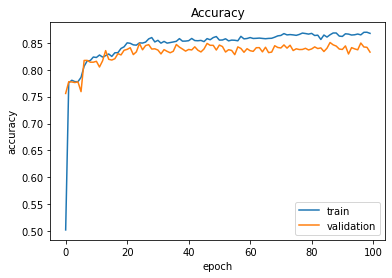

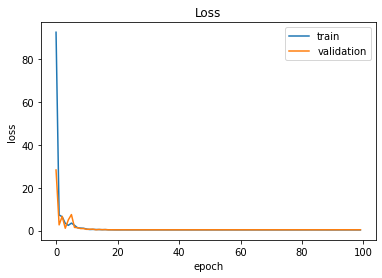

In [19]:
#@title First Model

run_this_model=1  #1: 訓練這個模型; 0: 跳過此段落

if(run_this_model):

  # 建模
  model = models.Sequential()             # Sequential 類神經網路模型

  # Input layer
  # is added automatically by keras.

  # Hidden Layers
  model.add(Dense(units=128,    # 神經元數目
                  input_dim=X_train.shape[1],     # 第一層隱藏層要設定 input_dim 當作是輸入層的神經元數目
                  activation='relu'   # relu 是活化函數的一種
                  ))
  
  model.add(Dense(units=128, activation='relu'))  # 第二層隱藏層開始就不用設定輸入數目了
  model.add(Dense(units=128, activation='relu'))

  # Output Layer
  model.add(Dense(units=1, activation='sigmoid')) # Sigmoid 是活化函數的一種

  # 編譯
  optimizer = Adam(learning_rate=0.01)    # Adam 是梯度下降法的一種，設定學習率
  model.compile(optimizer=optimizer,          # 引入剛剛設定好的梯度下降法
                loss='binary_crossentropy',   # 交叉熵 (crossentropy) 是一種損失函數
                metrics=['accuracy'])         # 判斷模型性能的目標參數
  
  model.summary()

  # 訓練
  history1 = model.fit(X_train,   # 訓練資料題目
                       Y_train,   # 訓練資料答案
                       batch_size=4096,   # 一次訓練的量
                       epochs=100,        # 訓練總代數
                       verbose=1,         # 是否顯示訓練過程
                       validation_data=[X_val,Y_val])    # 驗證資料

  # 印出訓練軌跡
  history_plt(history1)

In [20]:
#@title Second Model

run_this_model=0

if(run_this_model):
  optimizer = Adam(learning_rate=0.03)
  model = models.Sequential()
  model.add(Dense(units=256, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(units=2000, activation='relu'))
  model.add(Dense(units=2000, activation='relu'))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  
  model.summary()

  history2 = model.fit(X_train, Y_train, batch_size=4096, epochs=50, verbose=1, 
                      validation_data=[X_val,Y_val])
  history_plt(history2)

In [21]:
#@title Third Model

run_this_model=0

if(run_this_model):
  optimizer = Adam(learning_rate=0.01)
  model = models.Sequential()
  model.add(Dense(units=256, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()

  history3 = model.fit(X_train, Y_train, batch_size=4096, epochs=150, verbose=0, 
                      validation_data=[X_val,Y_val])

  history_plt(history3)

In [22]:
#@title Find the best accuracy
do_find_best = 0

if(do_find_best):
  learning_rate = [0.01, 0.003, 0.0001]
  epochs = [50, 100, 150, 200]
  layers = [3, 4, 5]
  history=[]
  best_acc=0
  for l in learning_rate:
    for e in epochs:
      for la in layers:
        optimizer = Adam(learning_rate=l)
        model = models.Sequential()
        model.add(Dense(units=256, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(0.3))
        for i in range(la-1):
          model.add(Dense(units=256, input_dim=X_train.shape[1], activation='relu'))
          model.add(Dropout(0.3))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        history_tmp=model.fit(X_train, Y_train, batch_size=4096, epochs=e, verbose=0, 
                            validation_data=[X_val,Y_val])
        history.append(history_tmp)
        history_plt(history_tmp)
        if(history_tmp.history['val_accuracy'][-1]>best_acc):
          best_acc=history_tmp.history['val_accuracy'][-1]
          best_settings = [l, e, la]

In [23]:
#@title Fourth Model
run_this_model=0

if (run_this_model):
  best_settings = [0.01, 100, 3]

  print(best_settings)

  optimizer = Adam(learning_rate=best_settings[0])
  model = models.Sequential()

  # Hidden Layer
  model.add(Dense(units=256, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(0.3))

  for i in range(best_settings[2]-1):
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.3))

  # Output Layer
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()

  history4 = model.fit(X_train, Y_train, batch_size=4096, epochs=best_settings[1], verbose=1, 
                      validation_data=[X_val,Y_val])
  history_plt(history4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               14080     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,209
Trainable params: 14,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 1s 21ms/step - loss: 13725.8398 - accuracy: 0.6389 - val_loss: 9383.6426 - val_accuracy: 0.7772
Epoch 2/100
14/14 [==============================] - 0s 13ms/step - loss: 7943.7046 - accuracy: 0.7290 - val_loss: 5350.0293 - val_accuracy: 0.7772
Epoch 3/100
14/14

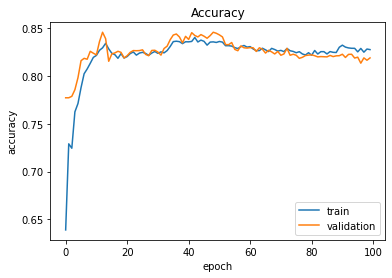

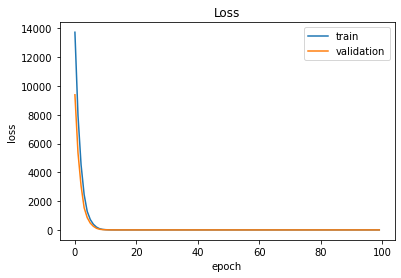

In [24]:
#@title Best Model

from tensorflow.keras import regularizers

optimizer = Adam(learning_rate=0.002)
model = models.Sequential()

# Hidden Layer
model.add(Dense(units=128,
                input_dim=X_train.shape[1],
                activity_regularizer=regularizers.L2(0.0005),
                activation='relu'))
model.add(Dropout(0.3))

# model.add(Dense(units=128,
#                 activity_regularizer=regularizers.L2(0.001),
#                 activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history5 = model.fit(X_train, 
                     Y_train, 
                     batch_size=2000, 
                     epochs=100, 
                     verbose=1,
                     shuffle=True,
                     validation_data=[X_val,Y_val])
history_plt(history5)


In [25]:
# Save model

model.save('/content/drive/MyDrive/GDSC-AI/model')

In [26]:
# Load model

# from keras import models
# model = models.load_model('/content/drive/MyDrive/GDSC-AI/model')
# 
# model.fit(X_test, Y_test)

### Step4. 模型預測
模型訓練完之後就可以拿來使用了。

直接執行 `model.predict()` 來預測我們的 X_test ，並且和 Y_test 進行比較。

預測結果 Y_predict 會是一個機率矩陣，**代表 X_test 當中每比資料年收入 >50K 的機率**，我們自己設定一個閥直，如果機率大於0.5我們就設定他的年收入一定 >50K。

```python
Y_predict_bin = np.where(Y_predict > 0.5, 1, 0)
```

再來，我們用 Confusion matrix 看看模型的預測狀況。

509/509 [==============================] - 3s 6ms/step
alpha_error : 0.22
beta_error : 0.16
MSE: 0.20


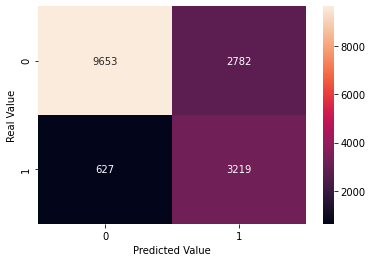

In [42]:
#@title Predict

from sklearn.metrics import confusion_matrix

# Predict
Y_predict = model.predict(X_test)

# Confusion matrix (CM)
threshold = 0.31

Y_predict_bin = np.where(Y_predict > threshold, 1, 0)   #二元化訓練結果
result = confusion_matrix(Y_test, Y_predict_bin)  #生成CM

# Plot CM
result_df = pd.DataFrame(result, range(2), range(2))
sns.heatmap(result_df, annot=True, fmt="g")
plt.ylabel('Real Value')
plt.xlabel('Predicted Value')

# Validating the errors
alpha_err = result[0,1] / (result[0,0] + result[0,1]) # 偽陽性機率
beta_err = result[1,0] / (result[1,0] + result[1,1])  # 偽陰性機率
print("alpha_error : {:.2f}".format(alpha_err))
print("beta_error : {:.2f}".format(beta_err))
mse = np.sqrt((alpha_err*alpha_err+beta_err*beta_err)/2)
print("MSE: {:.2f}".format(mse))

plt.show()